In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
sp500 = pd.read_csv('monthly sp500 Trading Strategy v2.csv')
sp500.head(10)

,TICKER,date,SICCD,COMNAM,market_cap,SHROUT,VOL,PRC,ASKHI,BIDLO,...,Ask_minus_Bid,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_2,move_avg_3,lasso_pred,pred_forest,log_pred
0,A,2023-03-31,3825,AGILENT TECHNOLOGIES INC,0.598013,0.819430,-0.481976,0.576985,0.687603,0.639317,...,0.090984,6,0,1,1,1,1,0.022064,0.006925,Positive
1,A,2023-04-30,3826,AGILENT TECHNOLOGIES INC,0.639969,0.569702,-1.002431,0.631267,0.401041,0.631526,...,-0.664249,6,0,0,1,1,1,0.001219,-0.109887,Negative
2,A,2023-05-31,3826,AGILENT TECHNOLOGIES INC,-0.030178,0.559246,0.712503,-0.052604,0.088033,-0.418793,...,1.400101,6,0,0,1,1,1,0.029832,0.103218,Positive
3,A,2023-06-30,3826,AGILENT TECHNOLOGIES INC,-0.685944,0.339669,1.644514,-0.713482,-0.925257,-0.356475,...,-1.519656,5,0,1,1,1,1,0.056086,0.032090,Positive
4,A,2023-07-31,3826,AGILENT TECHNOLOGIES INC,-0.420183,0.339669,0.216209,-0.441817,-0.430748,-0.250592,...,-0.472740,5,0,0,1,0,1,-0.014129,-0.045487,Negative
5,A,2023-08-31,3826,AGILENT TECHNOLOGIES INC,-0.344615,0.339669,-0.038929,-0.364570,-0.431472,-0.131961,...,-0.803705,5,0,0,1,1,0,-0.010278,-0.070240,Negative
6,A,2023-09-30,3826,AGILENT TECHNOLOGIES INC,-0.994696,0.241270,0.416554,-1.025396,-0.888667,-0.721929,...,-0.406939,5,0,0,1,1,1,-0.030656,-0.101629,Negative
7,A,2023-10-31,3826,AGILENT TECHNOLOGIES INC,-1.402365,-1.628310,0.799163,-1.373923,-1.602355,-1.585987,...,0.054647,5,0,1,1,1,1,0.000904,0.063396,Negative
8,A,2023-11-30,3826,AGILENT TECHNOLOGIES INC,-0.982589,-1.628310,0.986257,-0.940732,-0.543054,-1.340934,...,2.246689,5,0,0,1,0,0,0.026572,0.067781,Positive
9,ABBV,2023-03-31,2834,ABBVIE INC,0.964325,1.291127,1.397388,0.946178,0.648974,1.072496,...,-0.193673,9,1,1,1,0,1,-0.041041,0.038438,Negative


In [3]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TICKER             4338 non-null   object 
 1   date               4338 non-null   object 
 2   SICCD              4338 non-null   int64  
 3   COMNAM             4338 non-null   object 
 4   market_cap         4338 non-null   float64
 5   SHROUT             4338 non-null   float64
 6   VOL                4338 non-null   float64
 7   PRC                4338 non-null   float64
 8   ASKHI              4338 non-null   float64
 9   BIDLO              4338 non-null   float64
 10  total              4338 non-null   int64  
 11  negative           4338 non-null   int64  
 12  positive           4338 non-null   int64  
 13  sprtrn             4338 non-null   float64
 14  RET                4338 non-null   float64
 15  next_month_return  4338 non-null   float64
 16  last_month_return  4338 

In [4]:
# Change date column to datetime with %Y-%m-%d format
sp500['date'] = pd.to_datetime(sp500['date'], format='%Y-%m-%d')

# Change SICCD column to object
sp500['SICCD'] = sp500['SICCD'].astype(str)

# Change proper. column to object
sp500['proper'] = sp500['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(sp500.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TICKER             4338 non-null   object        
 1   date               4338 non-null   datetime64[ns]
 2   SICCD              4338 non-null   object        
 3   COMNAM             4338 non-null   object        
 4   market_cap         4338 non-null   float64       
 5   SHROUT             4338 non-null   float64       
 6   VOL                4338 non-null   float64       
 7   PRC                4338 non-null   float64       
 8   ASKHI              4338 non-null   float64       
 9   BIDLO              4338 non-null   float64       
 10  total              4338 non-null   int64         
 11  negative           4338 non-null   int64         
 12  positive           4338 non-null   int64         
 13  sprtrn             4338 non-null   float64       
 14  RET     

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_month_return' column
sp500.dropna(subset=['next_month_return'], inplace=True)

# Select only numeric columns
numeric_columns = sp500.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[sp500['next_month_return'] >= 0]
negative_return = numeric_columns[sp500['next_month_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_next_month_return'] = mean_negative_return
result_df['mean_positive_next_month_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                   negative_next_month_return  \
market_cap                              0.227   
SHROUT                                  0.012   
VOL                                    -0.210   
PRC                                     0.231   
ASKHI                                   0.228   
BIDLO                                   0.276   
total                                   6.536   
negative                                0.052   
positive                                0.834   
sprtrn                                 -0.290   
RET                                    -0.103   
next_month_return                      -0.063   
last_month_return                       0.026   
last_month_volume                      -0.016   
X1_month_ma                             0.231   
X2_month_ma                             0.298   
X3_month_ma                             0.350   
Ask_minus_Bid                          -0.079   
comp_size                               4.448   
dummy_negative      

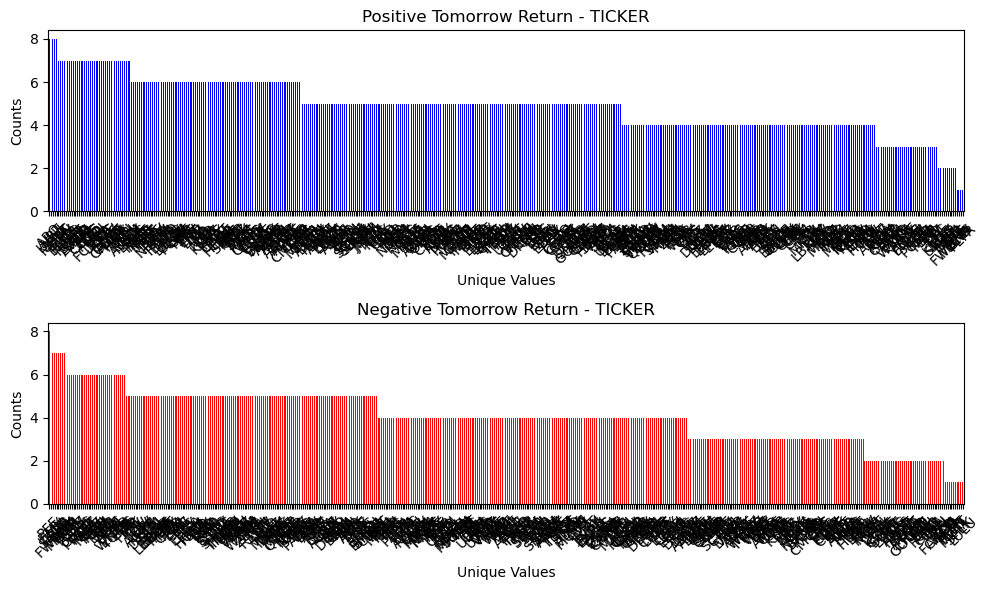

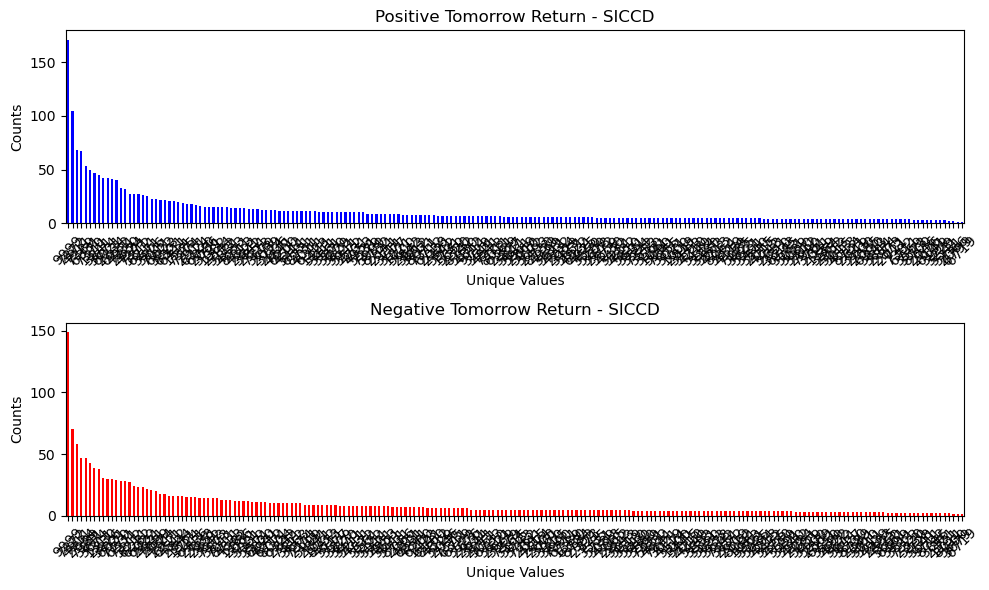

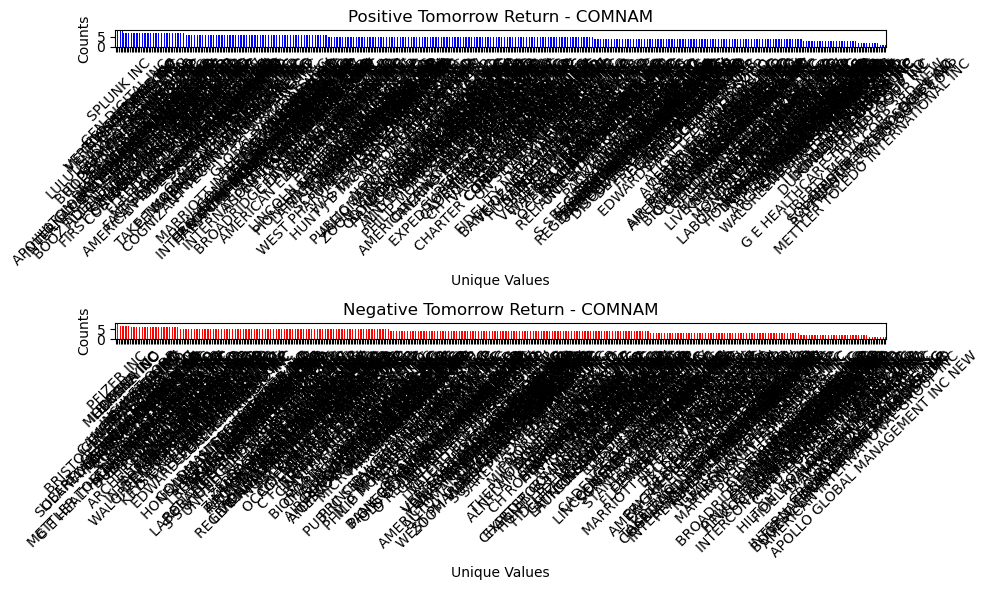

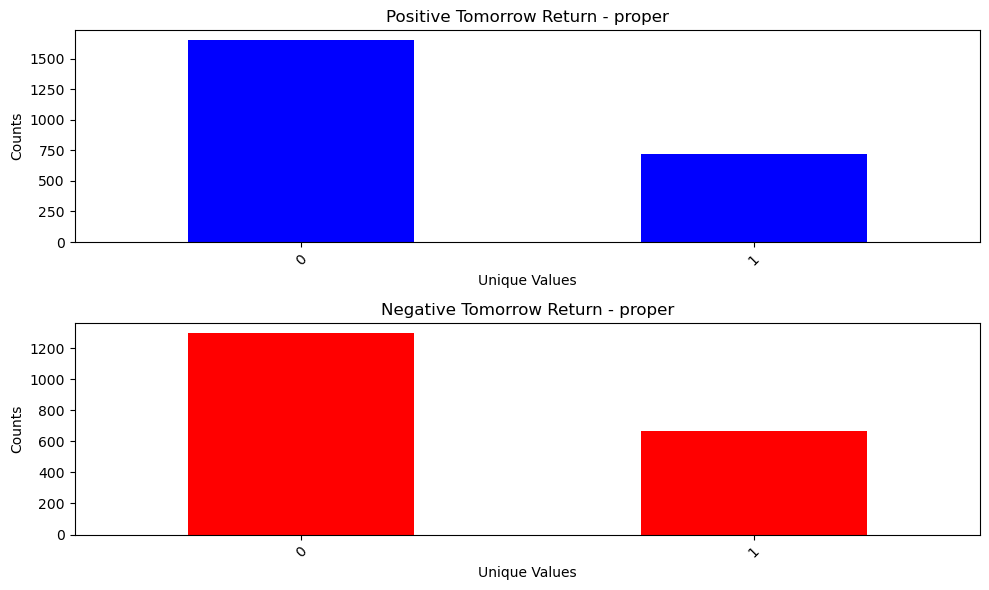

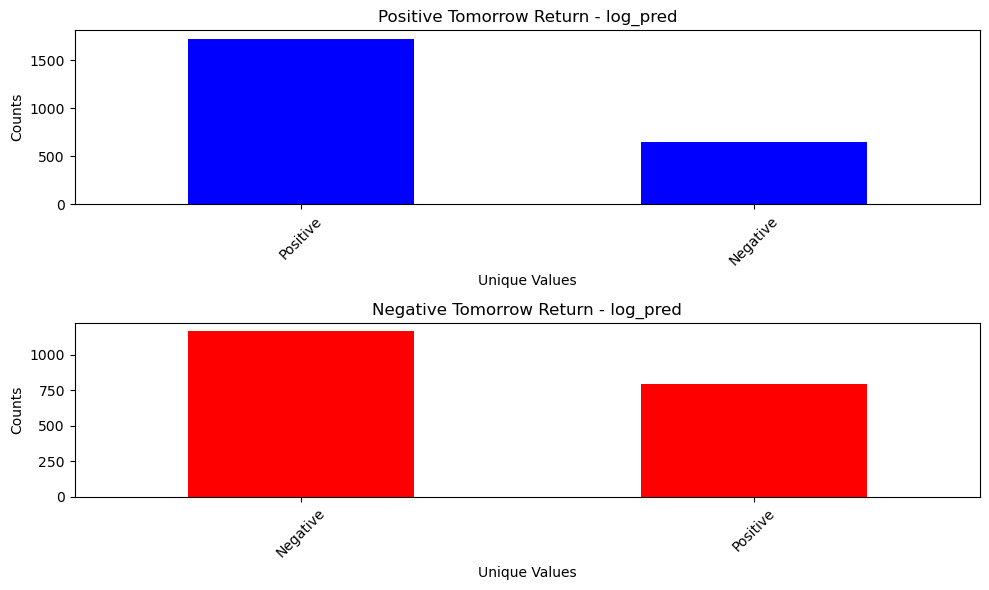

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_month_return' column
sp500.dropna(subset=['next_month_return'], inplace=True)

# Select only categorical columns
categorical_columns = sp500.select_dtypes(include=['object'])

# Create subsets
positive_return = sp500[sp500['next_month_return'] >= 0]
negative_return = sp500[sp500['next_month_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

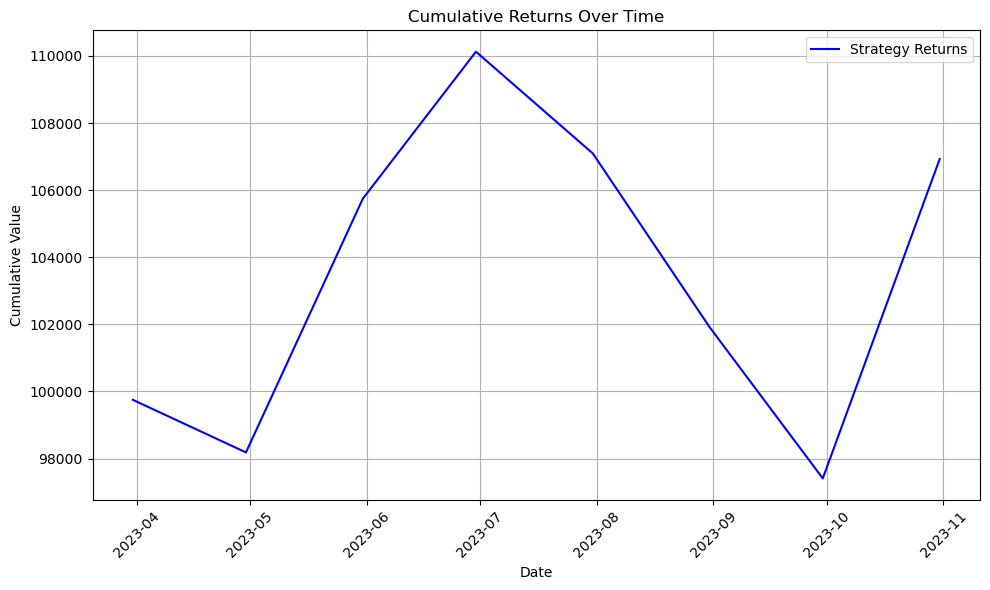

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy.loc[(sp500_copy['dummy_total'] == 1), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


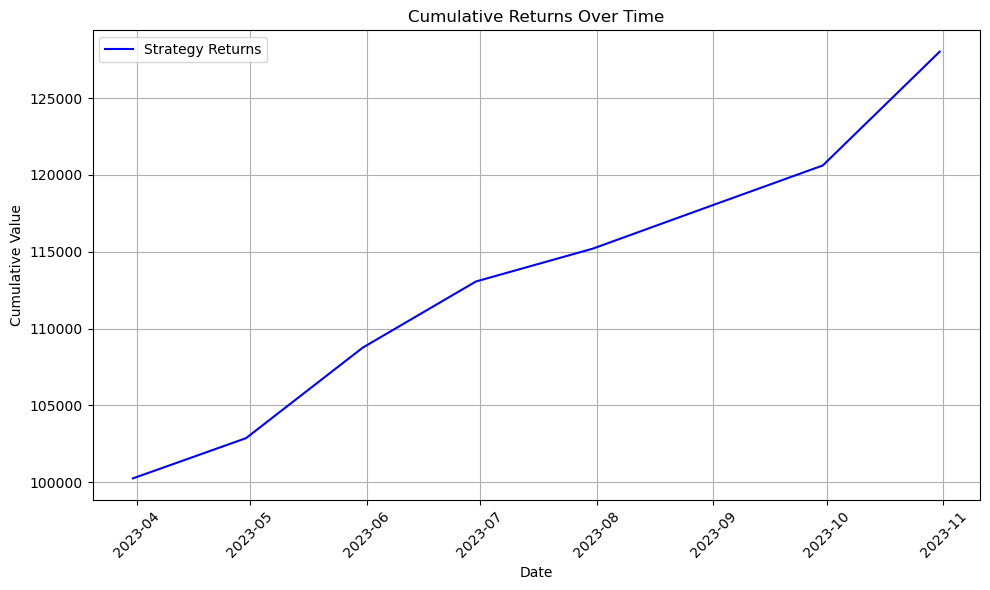

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['lasso_pred'] > 0), 'position'] = 1
sp500_copy.loc[(sp500_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


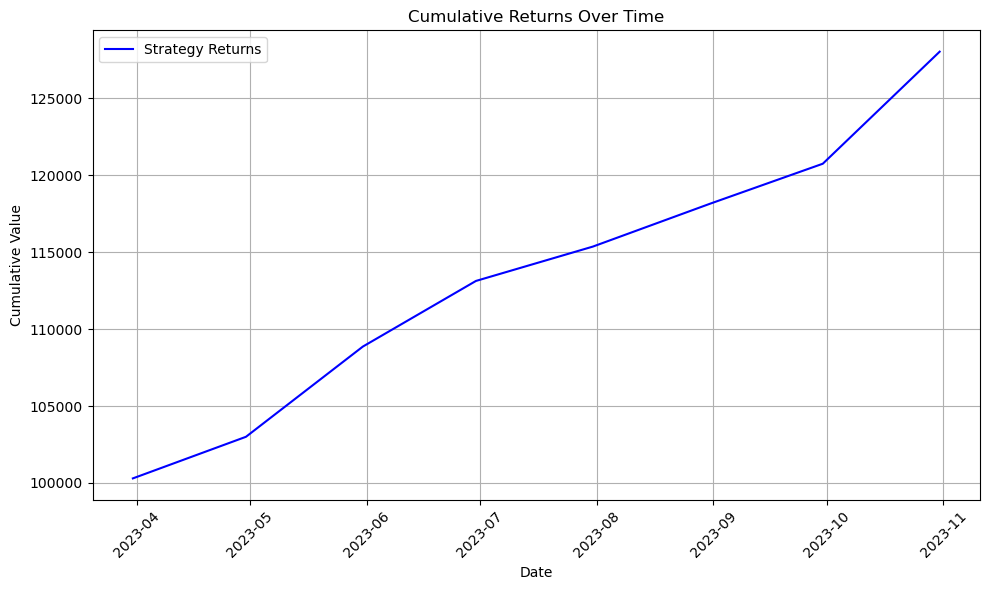

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


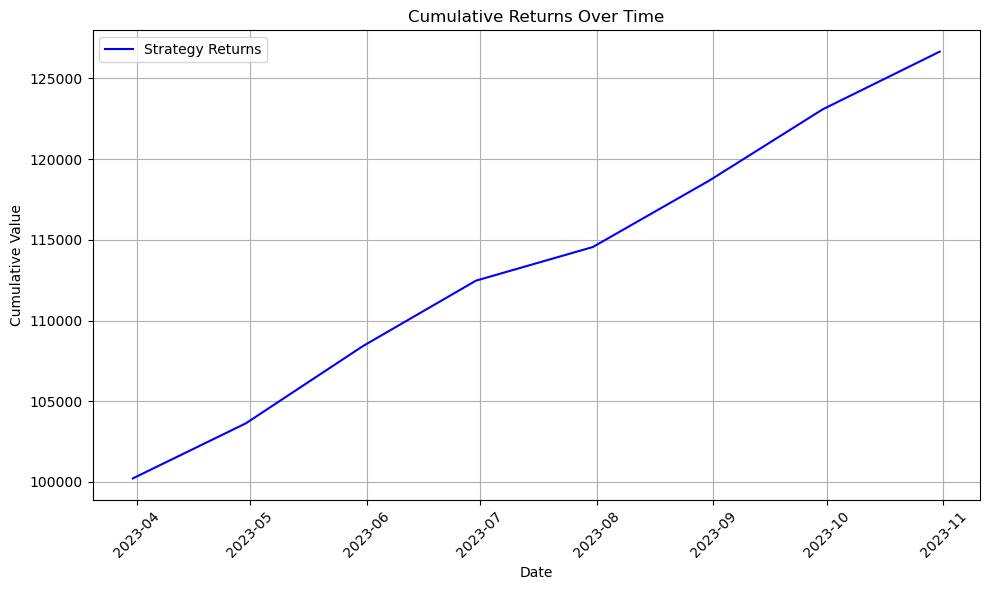

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['log_pred'] == 'Positive'), 'position'] = 1
sp500_copy.loc[(sp500_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


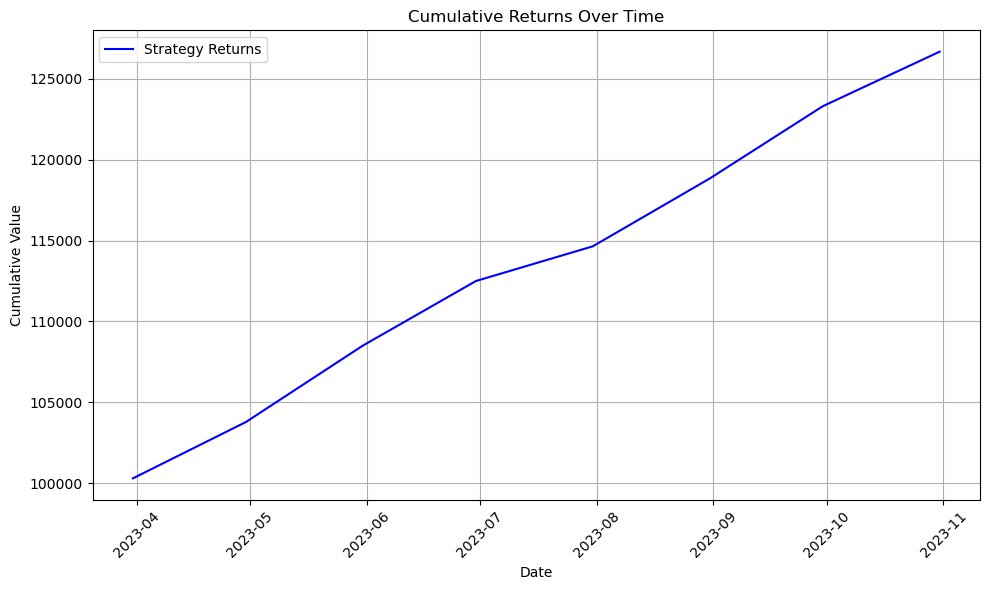

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['log_pred'] == 'Positive') & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['log_pred'] == 'Negative') & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


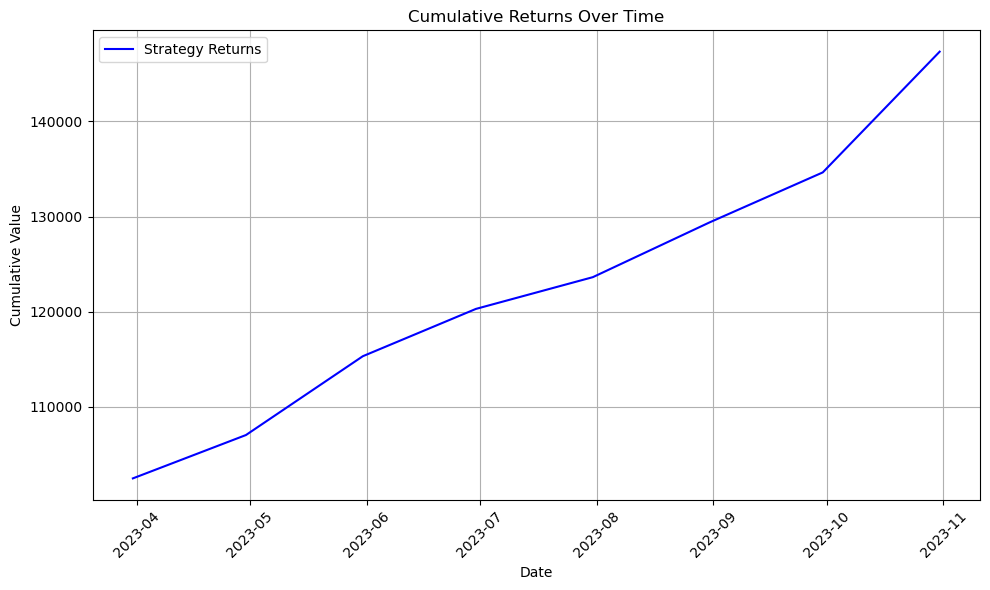

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


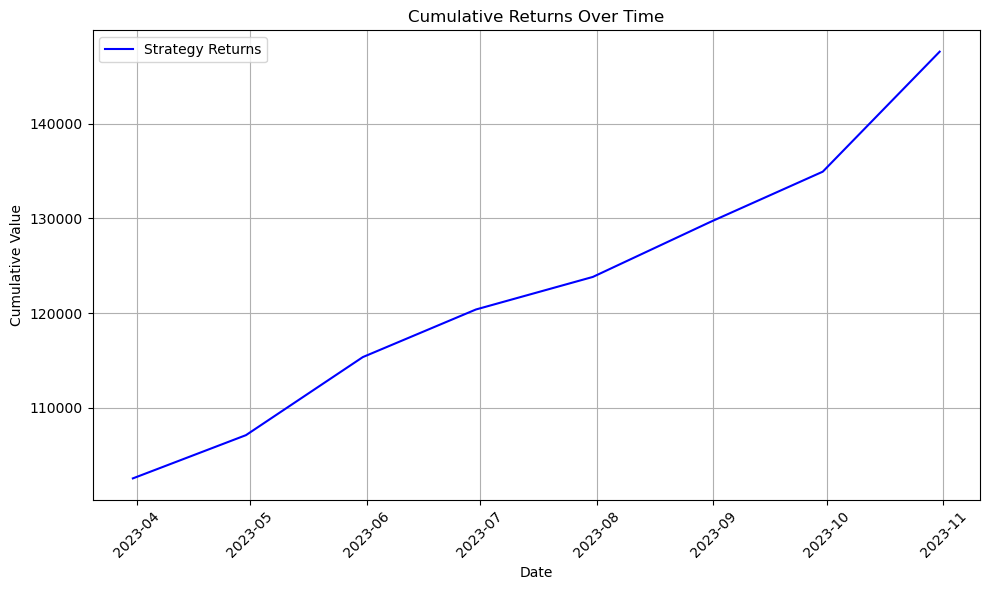

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


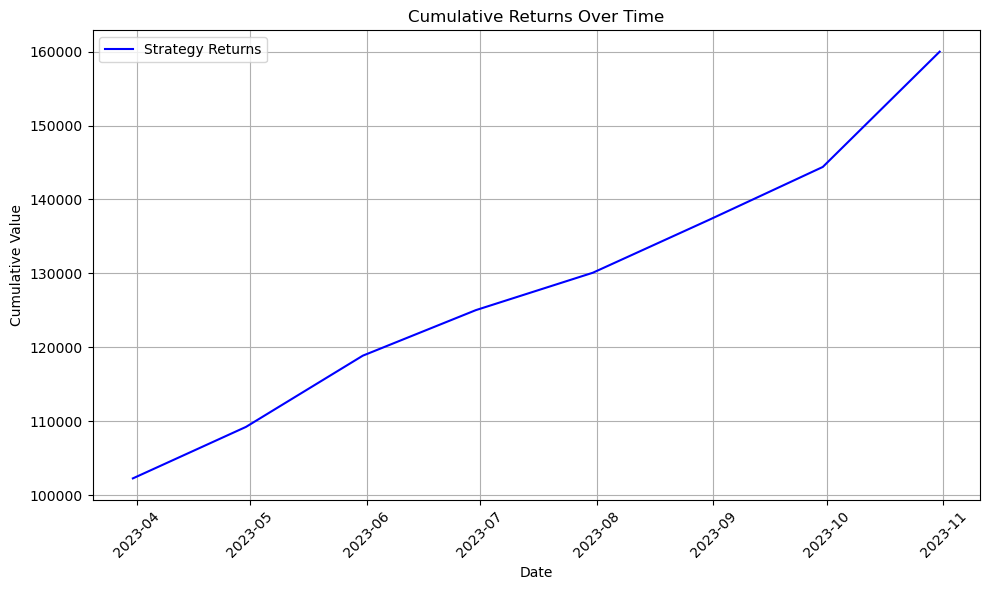

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


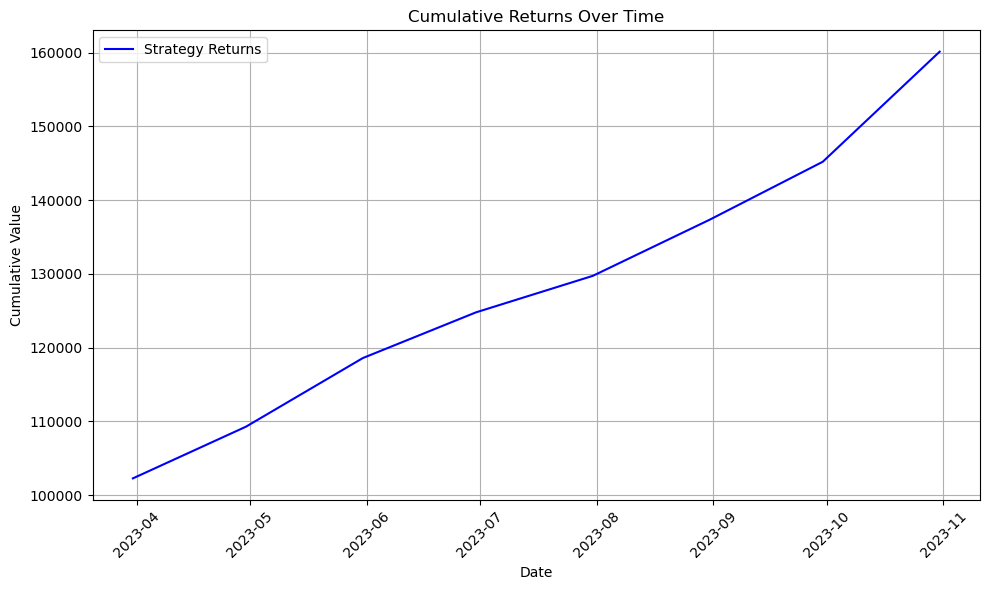

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['log_pred'] == 'Positive') & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['log_pred'] == 'Negative') & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


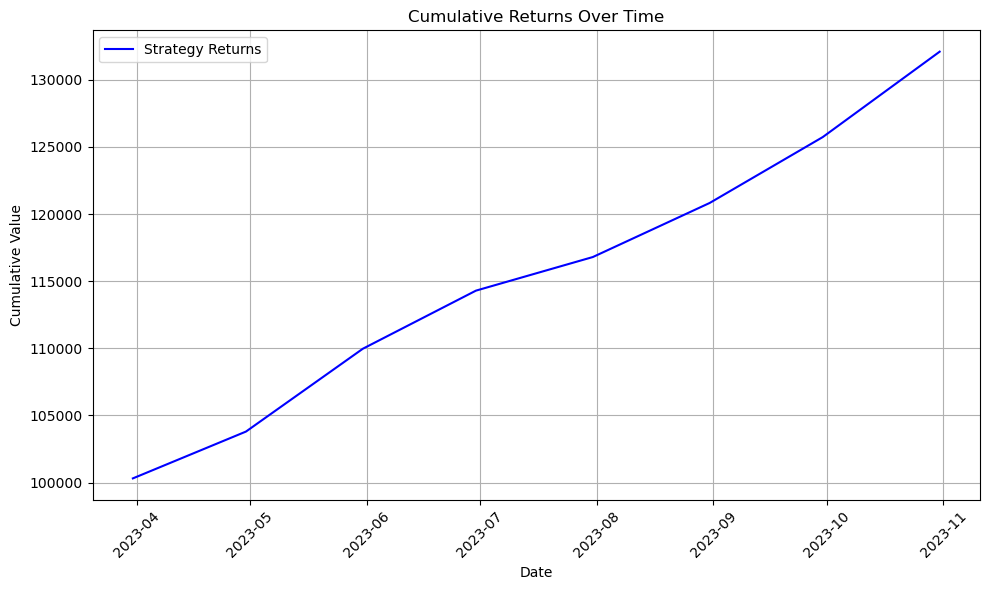

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['log_pred'] == 'Positive') & (sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1), 'position'] = 1
sp500_copy.loc[(sp500_copy['log_pred'] == 'Negative') & (sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


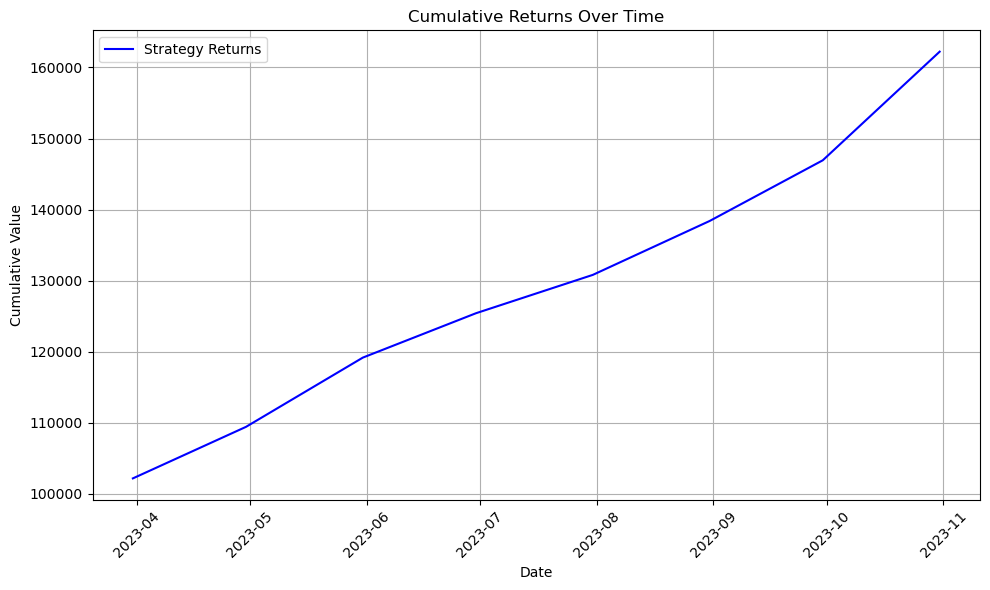

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
sp500_copy = sp500.copy()

# Convert 'date' column to datetime format
sp500_copy['date'] = pd.to_datetime(sp500_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
sp500_copy = sp500_copy[sp500_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
sp500_copy['position'] = 0
sp500_copy.loc[(sp500_copy['pred_forest'] > 0) & (sp500_copy['lasso_pred'] > 0) & (sp500_copy['dummy_total'] == 1) & (sp500_copy['log_pred'] == 'Positive'), 'position'] = 1
sp500_copy.loc[(sp500_copy['pred_forest'] < 0) & (sp500_copy['lasso_pred'] < 0) & (sp500_copy['dummy_total'] == 1) & (sp500_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate monthly mode of 'sprtrn' for S&P 500
monthly_mode_sprtrn = sp500_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = sp500_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = sp500_copy[sp500_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = monthly_mode_sprtrn[monthly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_month_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
